<a href="https://colab.research.google.com/github/chinmay002/Tensorflow_cert_progress/blob/main/TF_NLP_SKIMLIT._V1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers,models
from tensorflow.keras.layers import Dense,Conv1D,Input
from tensorflow.keras.models import Model,Sequential

from sklearn.metrics import classification_report,confusion_matrix,f1_score,accuracy_score,precision_score,recall_score
import random,os,glob
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline


In [ ]:

!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 7.84 MiB/s, done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
data_dir  ='/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'

In [ ]:
def get_lines(filename):
  with open(filename,'r') as f:
    '''
    Returns:
    A list of strings with one string per line from the target filename
    '''
    return f.readlines()


In [ ]:
train_lines = get_lines(data_dir+'/train.txt')


In [ ]:
for line in train_lines[:27]:
  if line.isspace():
    print('line')
  else:
    print(line)

NameError: ignored



```

 [{line_numer:0,
 'target':'OBJECTIVE',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'total_lines :11'}]
```




In [ ]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
     #print(f'abstract_id {abstract_id}')
     # print(f'abstract_lines {abstract_lines}')
     # print()
    elif line.isspace(): #splits on space, her eafter each set, there is extrac line. so it divides on that basis. 
      abstract_line_split = abstract_lines.splitlines()  #[obj,methods,result],[obj,method,result]....
      #print(f'abstract_line_split {abstract_line_split}')

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  
  return abstract_samples

In [ ]:
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "/train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "/dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "/test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 382 ms, sys: 78.2 ms, total: 460 ms
Wall time: 479 ms


(180040, 30212, 30135)

In [ ]:
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

In [ ]:
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)
     

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


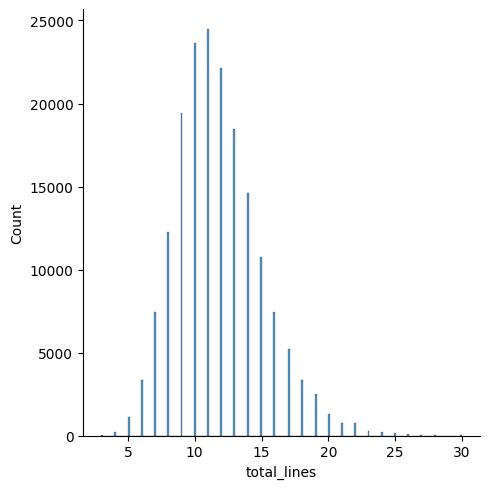

In [ ]:
sns.displot(train_df['total_lines'])

In [ ]:
train_sent = train_df['text'].tolist()
val_sent = val_df['text'].tolist()
test_sent = test_df['text'].tolist()

In [ ]:
train_sent[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
train_labels_ohe = ohe.fit_transform(train_df['target'].values.reshape(-1, 1))
val_labels_ohe = ohe.fit_transform(val_df['target'].values.reshape(-1, 1))
test_labels_ohe = ohe.fit_transform(test_df['target'].values.reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
train_labels_ohe

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

# Label Encoder

In [ ]:
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
train_labels_encoded = lb.fit_transform(train_df['target'].to_numpy())
test_labels_encoded = lb.fit_transform(test_df['target'].to_numpy())
val_labels_encoded = lb.fit_transform(val_df['target'].to_numpy())

In [ ]:
n_classes,class_names = len(lb.classes_),lb.classes_

#Model 0: Baseline

In [ ]:
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sent, 
            y=train_labels_encoded);
     

In [ ]:
print(model_0.score(X=val_sent,y=val_labels_encoded))

# Make predictions
baseline_preds = model_0.predict(val_sent)
baseline_preds


0.7218323844829869


array([4, 1, 3, ..., 4, 4, 1])

In [ ]:
def plot_loss_curve(history):
  
  acc = history.history['accuracy']
  loss = history.history['loss']

  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']

  fig = plt.figure(figsize=(10,5))

  plt.subplot(221)
  plt.plot(acc,'bo--', label = "acc")
  plt.plot(val_acc,'ro--',label = 'val_acc')
  plt.ylabel('accuracy')
  plt.xlabel('epochs')
  plt.title('acc vs val_acc')
  plt.legend()

  plt.subplot(222)
  plt.plot(loss,'bo--', label = "loss")
  plt.plot(val_loss,'ro--',label = 'val_acc')
  plt.ylabel('Loss')
  plt.xlabel('epochs')
  plt.title('loss vs val_loss')
  plt.legend()
  plt.show()

def unzip_data(file):
  zip_file = zipfile.ZipFile(file)
  zip_file.extractall()
  zip_file.close()


import datetime

def create_tensorboard_callback(dir_name,experiment_name):
  
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback


def calculate(y_true_,y_pred):
  acc = accuracy_score(y_true_,y_pred)
  f1 = f1_score(y_true_,y_pred,average = 'weighted')
  recall = recall_score(y_true_,y_pred,average = 'weighted')
  precision = precision_score(y_true_,y_pred,average = 'weighted')

  print('Recall: ', recall)
  print('precision: ', precision)
  print('f1: ', f1)
  print('accuracy: ', acc)
  return {'accuracy': acc,
          'f1': f1,
          'precision': precision,
          'Recall': recall,}


In [ ]:
baseline_results = calculate(val_labels_encoded,baseline_preds)

NameError: ignored

In [ ]:
#max_length avg_sentnece lentgth
sum(train_df['text'].str.split(' ').str.len())/len(train_df)



26.338269273494777

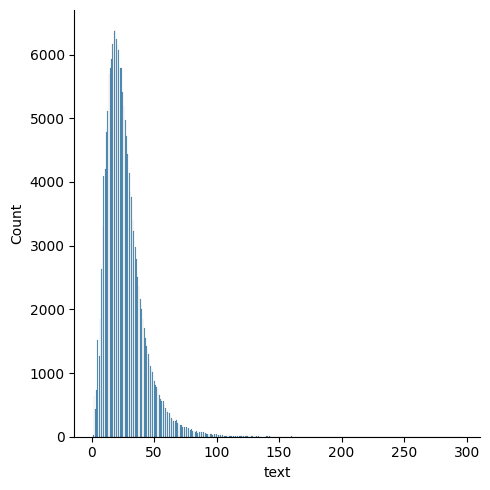

In [ ]:
sns.displot(train_df['text'].str.split(' ').str.len())

In [ ]:
#skwed token_length 
output_seq_len = np.percentile(train_df['text'].str.split(' ').str.len(),95)
output_seq_len

#looks loke 95% of the token_lentgh have 55 tokens in sentence

55.0

In [ ]:
import nltk
tr = ' '.join(train_df['text'].str.lower())


In [ ]:
import nltk
nltk.download('punkt')
nltk.FreqDist(nltk.word_tokenize(tr))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


FreqDist({'@': 337420, ',': 196305, '.': 180578, 'the': 171178, 'and': 137947, 'of': 130660, ')': 129028, '(': 128312, 'in': 106651, 'to': 76228, ...})

In [ ]:
len(nltk.word_tokenize(tr))

4846116

In [ ]:
max_tokens = 68000
max_tokens

68000

# Tokenizer

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import TextVectorization

In [ ]:
sample = 'This is very good for us. we got RA position'

In [ ]:
tokenizer = Tokenizer(num_words = max_tokens,
                      oov_token="<OOV>",lower=True)

tokenizer.fit_on_texts([sample])

In [ ]:
tokenizer.word_index

{'<OOV>': 1,
 'this': 2,
 'is': 3,
 'very': 4,
 'good': 5,
 'for': 6,
 'us': 7,
 'we': 8,
 'got': 9,
 'ra': 10,
 'position': 11}

In [ ]:
pad_sequences(tokenizer.texts_to_sequences([sample]),maxlen = 15,padding = 'post',truncating = 'post')

array([[ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  0,  0,  0,  0,  0]],
      dtype=int32)

In [ ]:
tv_sample = TextVectorization(max_tokens=15,
                       standardize = 'lower_and_strip_punctuation',
                       split = 'whitespace',
                       ngrams = None,
                       pad_to_max_tokens=True,
                      output_mode = 'int',
                       output_sequence_length = int(output_seq_len))

In [ ]:
tv_sample.adapt([sample])

In [ ]:
tv_sample.get_vocabulary()

['',
 '[UNK]',
 'we',
 'very',
 'us',
 'this',
 'ra',
 'position',
 'is',
 'got',
 'good',
 'for']

In [ ]:
tv_sample([sample])

<tf.Tensor: shape=(1, 55), dtype=int64, numpy=
array([[ 5,  8,  3, 10, 11,  4,  2,  9,  6,  7,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0]])>

In [ ]:
max_tokens

68000

In [ ]:
max_tokens_tok = 40000
tokenizer = Tokenizer(num_words = max_tokens_tok,oov_token = '<oov>',lower = True)
tokenizer.fit_on_texts(train_sent)
train_seq = pad_sequences(tokenizer.texts_to_sequences(train_sent),maxlen = int(output_seq_len),padding = 'post',truncating ='post' )
val_seq = pad_sequences(tokenizer.texts_to_sequences(val_sent),maxlen = int(output_seq_len),padding = 'post',truncating ='post' )
test_seq = pad_sequences(tokenizer.texts_to_sequences(test_sent),maxlen = int(output_seq_len),padding = 'post',truncating ='post' )

In [ ]:
word_index  = tokenizer.word_index

In [ ]:
embedding_tok = layers.Embedding(max_tokens_tok,output_dim = 100,)

In [ ]:
len(word_index.keys())

45901

In [ ]:
a = pad_sequences(tokenizer.texts_to_sequences(['lets find find out about us acbdesd']),maxlen = int(output_seq_len),padding = 'post',truncating ='post' )
embedding_tok(a)

<tf.Tensor: shape=(1, 55, 100), dtype=float32, numpy=
array([[[ 0.0256098 ,  0.03332958, -0.00918032, ...,  0.00347112,
          0.0446532 , -0.01665979],
        [ 0.00433405,  0.03489346,  0.04133708, ...,  0.006506  ,
          0.03372128, -0.00529591],
        [ 0.00433405,  0.03489346,  0.04133708, ...,  0.006506  ,
          0.03372128, -0.00529591],
        ...,
        [-0.01742155, -0.0138446 ,  0.0417374 , ...,  0.03687128,
         -0.01733918,  0.04357794],
        [-0.01742155, -0.0138446 ,  0.0417374 , ...,  0.03687128,
         -0.01733918,  0.04357794],
        [-0.01742155, -0.0138446 ,  0.0417374 , ...,  0.03687128,
         -0.01733918,  0.04357794]]], dtype=float32)>

# TextVectorization

In [ ]:
from tensorflow.keras.layers import TextVectorization

tv = TextVectorization(max_tokens=max_tokens,
                       standardize = 'lower_and_strip_punctuation',
                       split = 'whitespace',
                       ngrams = None,
                       pad_to_max_tokens=True,
                       output_mode = 'int',
                       output_sequence_length = int(output_seq_len))

In [ ]:
tv.adapt(train_sent)

In [ ]:
sample_sent = random.choice(train_sent)
print(f"Original Train {sample_sent}")
print(f"tv train {tv(sample_sent)}")
print()
print(tv(sample_sent).shape)

Original Train in summary , non-adjuvanted gh@-qbeta showed similar antibody mediated immunogenicity and a comparable safety profile in healthy humans to commercially available vaccines .
tv train [    5  2483  9114 31145   147   150  1029  2268  1929     3     8   550
   136   596     5   247  1975     6  4837   559  1972     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]

(55,)


In [ ]:
rct_20k_vocab = (tv.get_vocabulary())
print(f"Number of words in vocabulary: {len(rct_20k_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [ ]:
#Embedding layer recieve a input as (batch, seq_len) ie (None,55)
#it outputs 3d [batch , seq_len , emb_dims]

token_emb = layers.Embedding(input_dim =len(rct_20k_vocab) ,output_dim = 128 ,
                             mask_zero=True,
                             name="token_embedding")

import random
random_text = random.choice(train_sent)
print(f"Original text {random_text}\n \
        \n\nEmbedded Version: ")
sample_embed = token_emb(tv([random_text]))
print(sample_embed)

Original text the intention-to-treat ( itt ) and per-protocol ( pp ) h.pylori eradication rates were @ % ( @/@ ) and @ % ( @/@ ) in the furazolidone-based quadruple group , and @ % ( @/@ ) and @ % ( @/@ ) in the levofloxacin-based quadruple group respectively ( ( @ ) = @ , @ ; p = @ , @ ) .
         

Embedded Version: 
tf.Tensor(
[[[-0.00590017 -0.03499372  0.03473126 ... -0.0036069   0.01417292
   -0.02801139]
  [-0.03972807  0.048652   -0.00215843 ... -0.01107597 -0.03325237
    0.02416733]
  [-0.04278529 -0.03088541 -0.03008542 ...  0.03728538 -0.02724358
    0.00255867]
  ...
  [ 0.03571591  0.01646412  0.04437313 ...  0.02352292  0.03280295
   -0.02599576]
  [ 0.03571591  0.01646412  0.04437313 ...  0.02352292  0.03280295
   -0.02599576]
  [ 0.03571591  0.01646412  0.04437313 ...  0.02352292  0.03280295
   -0.02599576]]], shape=(1, 55, 128), dtype=float32)


In [ ]:
ss1 = random.choice(train_sent)
ss2 = random.choice(train_sent)
token_emb(tv([ss1,ss2]))

<tf.Tensor: shape=(2, 55, 128), dtype=float32, numpy=
array([[[ 0.04450605, -0.03847174,  0.01743951, ...,  0.04210183,
          0.00906659,  0.00154834],
        [ 0.04129578,  0.0419069 ,  0.01822492, ...,  0.02936322,
         -0.01156842,  0.04301986],
        [ 0.0377854 , -0.04839056, -0.02795904, ...,  0.04973233,
         -0.04083163,  0.01894641],
        ...,
        [ 0.03571591,  0.01646412,  0.04437313, ...,  0.02352292,
          0.03280295, -0.02599576],
        [ 0.03571591,  0.01646412,  0.04437313, ...,  0.02352292,
          0.03280295, -0.02599576],
        [ 0.03571591,  0.01646412,  0.04437313, ...,  0.02352292,
          0.03280295, -0.02599576]],

       [[ 0.02722744, -0.01401793,  0.00614928, ...,  0.00526919,
          0.02785131,  0.02368196],
        [ 0.02135687, -0.03822146, -0.01865933, ...,  0.04539541,
          0.04812297,  0.02981002],
        [-0.00045667, -0.04113486,  0.03310969, ..., -0.03406968,
         -0.03800094, -0.03257245],
        ...,


In [ ]:
train_dataset_tv = tf.data.Dataset.from_tensor_slices((train_sent,train_labels_ohe)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset_tv = tf.data.Dataset.from_tensor_slices((test_sent,test_labels_ohe)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset_tv = tf.data.Dataset.from_tensor_slices((val_sent,val_labels_ohe)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
for a,b in train_dataset_tv.take(1):
  print(a,b)

tf.Tensor(
[b'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .'
 b'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .'
 b'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .'
 b'pain was assessed using the visual analog pain scale ( @-@ mm ) .'
 b'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .'
 b'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .'
 b'there 

In [ ]:
#these are for tokenizer 
train_dataset = tf.data.Dataset.from_tensor_slices((train_seq,train_labels_ohe)).batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_seq,test_labels_ohe)).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_seq,val_labels_ohe)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 55), dtype=tf.int32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
tf.data.Dataset.from_tensor_slices(([[1,]],[[0,0,0,0,0]]))

<_TensorSliceDataset element_spec=(TensorSpec(shape=(1,), dtype=tf.int32, name=None), TensorSpec(shape=(5,), dtype=tf.int32, name=None))>

# Model 1

In [ ]:
tv(train_sent[:32])

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)  # input is expected to be a 1-dimensional tensor.  (None,1)
text_vectors = tv(inputs) # vectorize text inputs   #                                                  (32,55)
token_embeddings = token_emb(text_vectors) # create embedding                                          (32,55,128)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)              (32,55,64)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector                      (32,64)
outputs = layers.Dense(n_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_1.summary()

In [ ]:
model_1.history = model_1.fit(train_dataset,epochs=3,
                              validation_data = val_dataset,
                              validation_steps = int(0.1*len(val_dataset)))

In [ ]:
model_1.evaluate(val_dataset)

In [ ]:
model_1_pred_probs = model_1.predict(val_dataset)
model_1_pred_probs = tf.argmax(model_1_pred_probs,axis=1)

In [ ]:
baseline_1_res = calculate(val_labels_encoded,model_1_pred_probs)

# Model 1 using Tokenizer

In [ ]:
embedding_tok = layers.Embedding(max_tokens_tok,output_dim = 100,)

inputs = Input(shape=(1,),name = 'input_shape')
emb_layer = embedding_tok(inputs)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(emb_layer)             # (32,55,64)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector                 #     (32,64)
outputs = layers.Dense(n_classes, activation="softmax")(x)
model_1_tok = Model(inputs,outputs)
model_1_tok.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_shape (InputLayer)    [(None, 1)]               0         
                                                                 
 embedding_5 (Embedding)     (None, 1, 100)            4000000   
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             32064     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_6 (Dense)             (None, 5)                 325       
                                                                 
Total params: 4,032,389
Trainable params: 4,032,389
Non-trainable params: 0
_________________________________________________

In [ ]:
model_1_tok.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_1_tok.history = model_1_tok.fit(train_dataset,epochs=3,
                              validation_data = val_dataset,
                              validation_steps = int(0.1*len(val_dataset)))

Epoch 1/3
5627/5627 [==============================] - 85s 13ms/step - loss: 0.6221 - accuracy: 0.7723 - val_loss: 0.5438 - val_accuracy: 0.8042
Epoch 2/3
5627/5627 [==============================] - 28s 5ms/step - loss: 0.4680 - accuracy: 0.8355 - val_loss: 0.5359 - val_accuracy: 0.8065
Epoch 3/3
5627/5627 [==============================] - 27s 5ms/step - loss: 0.4000 - accuracy: 0.8618 - val_loss: 0.5584 - val_accuracy: 0.8049


#Model 2: Feature Exctraction with pretrained token embeddings

In [ ]:
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
sample_sent = random.choice(train_sent)
print(sample_sent)
print()
print(token_emb(tv(sample_sent)).shape)
print()
print(tf_hub_embedding_layer([sample_sent]).shape)

a total of @ infants were enrolled in the sli group and @ in the control group .

(55, 128)

(1, 512)


In [ ]:
inputs = Input(shape=[],dtype = tf.string) #pretrained asks for size(batch,) hence shape= []
pretrained_emb = tf_hub_embedding_layer(inputs)   #takes input(None,seq_len)  -->(None,dim_len)
x = Dense(64,activation = 'relu')(pretrained_emb)   #inp(batch,dim)--->out(batch,dense_units)
outputs = Dense(5,activation = 'softmax')(x)       #inp(batch,64)----->(batch,5)
model_2 = Model(inputs,outputs)                           
model_2.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
Total params: 256,830,981
Trainable params: 33,157
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
ss1 = random.choice(train_sent)
ss2 = random.choice(train_sent)
tf_hub_embedding_layer([ss1,ss2])

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[ 0.06719957, -0.06695455, -0.02654888, ...,  0.02439315,
         0.00133406, -0.01466693],
       [ 0.06978687, -0.02663969,  0.10518183, ..., -0.01951362,
        -0.06846595, -0.09525921]], dtype=float32)>

In [ ]:
model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=val_dataset,
            validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 13s 17ms/step - loss: 0.9580 - accuracy: 0.6269 - val_loss: 0.8118 - val_accuracy: 0.6822
Epoch 2/3
562/562 [==============================] - 9s 16ms/step - loss: 0.7836 - accuracy: 0.6938 - val_loss: 0.7701 - val_accuracy: 0.7015
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7722 - accuracy: 0.7048 - val_loss: 0.7594 - val_accuracy: 0.7058


In [ ]:
print(model_2.evaluate(val_dataset))
model_2_pred_probs = model_2.predict(val_dataset)
model_2_pred_probs = tf.argmax(model_2_pred_probs,axis=1)
baseline_2_res = calculate(val_labels_encoded,model_2_pred_probs)

# Model 2- Feature Extraction using Tokenizer


In [ ]:
ss =['This is not good','Movie was a huge let down']

tf_hub_embedding_layer(ss)

<tf.Tensor: shape=(2, 512), dtype=float32, numpy=
array([[ 6.90572997e-05, -2.49395277e-02,  2.34257560e-02, ...,
        -3.01602650e-02, -1.03734145e-02,  2.46593859e-02],
       [-3.53581496e-02, -1.69337820e-02, -1.09568564e-03, ...,
        -5.36757261e-02,  1.11483090e-01,  7.73590477e-03]], dtype=float32)>

In [ ]:
inputs = Input(shape=[],dtype = tf.string) #pretrained asks for size(batch,) hence shape= []
pretrained_emb = tf_hub_embedding_layer(inputs)   #takes input(None,seq_len)  -->(None,dim_len)
x = Dense(64,activation = 'relu')(pretrained_emb)   #inp(batch,dim)--->out(batch,dense_units)
outputs = Dense(5,activation = 'softmax')(x)       #inp(batch,64)----->(batch,5)
model_2_tok = Model(inputs,outputs)                           
model_2_tok.compile(loss="categorical_crossentropy", # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
Dense(5,activation ='softmax')(Dense(64,activation ='relu')(tf_hub_embedding_layer(ss)))

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[0.19396418, 0.20140171, 0.20761006, 0.18669681, 0.21032721],
       [0.200833  , 0.20979857, 0.20973943, 0.18634802, 0.19328098]],
      dtype=float32)>

In [ ]:
model_2_tok.compile(loss="categorical_crossentropy",
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["accuracy"],
                    run_eagerly=True)

model_2_tok.fit(np.array(train_sent),
                train_labels_ohe,
                batch_size =32,
                steps_per_epoch=int(0.1 * len(train_sent) / 32),
                epochs=3,
                validation_data=(np.array(val_sent), val_labels_ohe),
                validation_steps=int(0.1 * len(val_sent)/32)
            )

Epoch 1/3


562/562 [==============================] - 39s 54ms/step - loss: 0.7410 - accuracy: 0.7127 - val_loss: 0.7194 - val_accuracy: 0.7174
Epoch 2/3
562/562 [==============================] - 29s 51ms/step - loss: 0.7300 - accuracy: 0.7219 - val_loss: 0.7181 - val_accuracy: 0.7241
Epoch 3/3
562/562 [==============================] - 29s 52ms/step - loss: 0.7069 - accuracy: 0.7313 - val_loss: 0.7028 - val_accuracy: 0.7334


5626.25

#Model 3 : Conv1d with character Embeding

In [ ]:
def char_split(sent):
  return ' '.join(list(sent))

char_split(sample_sent)

NameError: ignored

In [ ]:
train_chars = [char_split(sent) for sent in train_sent]
val_chars = [char_split(sent) for sent in val_sent]
test_chars = [char_split(sent) for sent in test_sent]

In [ ]:
train_chars[0]

't o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .'

In [ ]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sent]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

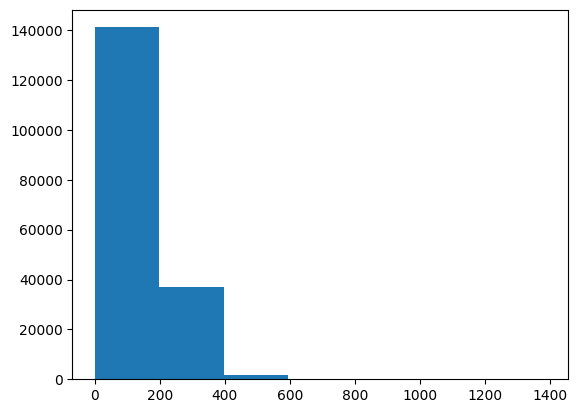

In [ ]:
# Check the distribution of our sequences at character-level
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7);

In [ ]:
output_seq_char_len = int(np.percentile(char_lens,95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet


'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
max_tokens = len(alphabet) + 2 #num_of_alphbets + space + oov
tv_char = TextVectorization(max_tokens=max_tokens,  
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")
tv_char.adapt(train_chars)


In [ ]:
print(train_chars[0])
print(tv_char(train_chars[0]))

t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .
tf.Tensor(
[ 3  7  4  6 21  2  9  3  4 18  5  3  2  3 13  2  2 17 17  4 11  5 11 19
  7 17 20  2  2 23  9  7 17 10  5  4 12 19 12  7 20 10  7  9  2  7  8  5
 12 14  8  2 10  6  4  9  7 12  7  6  2  4  6  4 15 14  8  7 21  4  6 18
 14  5  4  6 15  7 22  4 12  4  3 19  5  6 10  9 19  9  3  2 15  4 11 12
  7 20 18  8  5 10  2  4  6 17 12  5 15 15  5  3  4  7  6  4  6  3 13  2
  9 13  7  8  3  3  2  8 15  5  6 10 20 13  2  3 13  2  8  3 1

In [ ]:

# Create char embedding layer
char_embed = layers.Embedding(input_dim=max_tokens, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")
a = train_chars[0]

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{a}\n")
char_embed_example = char_embed(tv_char([a]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .

Embedded chars (after vectorization and embedding):
[[[-3.65224108e-02  1.82437412e-02 -1.54887326e-02 ... -4.07861695e-02
   -2.13705543e-02  4.73506711e-02]
  [-4.47373986e-02  4.53037731e-02 -1.27485506e-02 ...  3.78687419e-02
    2.36142017e-02 -1.78013444e-02]
  [-1.11378655e-02 -3.01375985e-05 -9.81808826e-03 ...  4.34682406e-02
    6.34051859e-04  2.89614536e-02]
  ...
  [-4

In [ ]:

# Make Conv1D on chars only
inputs = layers.Input(shape=(1,), dtype="string")                   #(None,1)
char_vectors = tv_char(inputs)                                      
char_embeddings = char_embed(char_vectors)                          #(1,seq_len, dim)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)   #(1,seq_len,units)
x = layers.GlobalMaxPool1D()(x)                       #(None,4=64)
outputs = layers.Dense(n_classes, activation="softmax")(x)  #(None,5)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_3.outputs

[<KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'dense_2')>]

In [ ]:
model_3.summary()

Model: "model_3_conv1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d (Conv1D)             (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 5

In [ ]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_ohe)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_ohe)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_ohe)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_3_history = model_3.fit(train_char_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_dataset)),
                              epochs=3,
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 11s 7ms/step - loss: 1.2791 - accuracy: 0.4897 - val_loss: 1.0673 - val_accuracy: 0.5758
Epoch 2/3
562/562 [==============================] - 4s 8ms/step - loss: 1.0136 - accuracy: 0.5919 - val_loss: 0.9608 - val_accuracy: 0.6200
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9354 - accuracy: 0.6273 - val_loss: 0.8862 - val_accuracy: 0.6543


In [ ]:
print(model_3.evaluate(val_dataset))
model_3_pred_probs = model_3.predict(val_dataset)
model_3_pred_pred = tf.argmax(model_3_pred_probs,axis=1)
baseline_3_res = calculate(val_labels_encoded,model_3_pred_pred)

#Model 3 : Conv1d with character Embedin wih Tockenixer


In [ ]:
max_tokens_tok = 40000
output_seq_len_char = 290

tokenizer_char = Tokenizer(num_words = None,oov_token = '<oov>',lower = True,char_level=True)
tokenizer_char.fit_on_texts(train_sent)
train_seq_char = pad_sequences(tokenizer_char.texts_to_sequences(train_sent),maxlen = int(output_seq_len_char),padding = 'post',truncating ='post' )
val_seq_char = pad_sequences(tokenizer_char.texts_to_sequences(val_sent),maxlen = int(output_seq_len_char),padding = 'post',truncating ='post' )
test_seq_char = pad_sequences(tokenizer_char.texts_to_sequences(test_sent),maxlen = int(output_seq_len_char),padding = 'post',truncating ='post' )

In [ ]:
sample = 'This is very good for us. we got RA position !@ 123/'
tokenizer_char = Tokenizer(num_words = None,oov_token = '<oov>',lower = True,char_level=True)
tokenizer.fit_on_texts(sample)
tokenizer.texts_to_sequences(sample)

[[117],
 [153],
 [228],
 [307],
 [],
 [228],
 [307],
 [],
 [653],
 [350],
 [346],
 [860],
 [],
 [131],
 [815],
 [815],
 [100],
 [],
 [548],
 [815],
 [346],
 [],
 [850],
 [307],
 [],
 [],
 [1402],
 [350],
 [],
 [131],
 [815],
 [117],
 [],
 [346],
 [8],
 [],
 [14],
 [815],
 [307],
 [228],
 [117],
 [228],
 [815],
 [38],
 [],
 [],
 [],
 [],
 [33238],
 [33239],
 [33240],
 []]

In [ ]:
tokenizer_char.word_index

{'<oov>': 1,
 ' ': 2,
 'e': 3,
 't': 4,
 'i': 5,
 'a': 6,
 'n': 7,
 'o': 8,
 'r': 9,
 's': 10,
 'd': 11,
 'c': 12,
 'l': 13,
 'h': 14,
 'p': 15,
 'm': 16,
 'u': 17,
 'f': 18,
 'g': 19,
 '@': 20,
 'y': 21,
 'w': 22,
 'v': 23,
 'b': 24,
 ',': 25,
 '.': 26,
 '-': 27,
 ')': 28,
 '(': 29,
 'k': 30,
 'x': 31,
 '%': 32,
 'z': 33,
 '=': 34,
 'q': 35,
 '/': 36,
 ';': 37,
 'j': 38,
 ':': 39,
 '<': 40,
 "'": 41,
 '+': 42,
 '`': 43,
 '>': 44,
 '$': 45,
 '&': 46,
 '*': 47,
 '~': 48,
 '?': 49,
 '#': 50,
 '_': 51,
 '!': 52,
 '|': 53,
 '"': 54,
 ']': 55,
 '\\': 56,
 '[': 57}

In [ ]:
from keras.layers import GlobalAveragePooling1D
char_embed = layers.Embedding(input_dim=len(tokenizer_char.word_index) + 1, # number of different characters
                              output_dim=100, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")


inputs = Input(shape=(1,),name = 'char_tokenizer_inp')
embedding_layer = char_embed(inputs)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(embedding_layer)   #(1,seq_len,units)
x = layers.GlobalMaxPool1D()(x)
x = Dense(64, activation = 'relu' ,name = 'char_layer_dense')(x)
outputs = Dense(5, activation = 'softmax' ,name = 'cahr_op')(x)
model_3_tok = Model(inputs,outputs)
model_3_tok.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 char_tokenizer_inp (InputLa  [(None, 1)]              0         
 yer)                                                            
                                                                 
 char_embed (Embedding)      (None, 1, 100)            5800      
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 64)             32064     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 char_layer_dense (Dense)    (None, 64)                4160      
                                                                 
 cahr_op (Dense)             (None, 5)                 325

In [ ]:
layers.GlobalMaxPool1D()(Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embed(train_seq_char[:1])))

<tf.Tensor: shape=(1, 64), dtype=float32, numpy=
array([[0.30660114, 0.30998814, 0.23365615, 0.28111234, 0.21755753,
        0.31541047, 0.2700096 , 0.25583962, 0.30702356, 0.33250996,
        0.31065807, 0.2610569 , 0.31783757, 0.23805177, 0.2383676 ,
        0.26371112, 0.2105386 , 0.3019485 , 0.30925947, 0.3448678 ,
        0.33950198, 0.32313704, 0.26437417, 0.28263772, 0.28195027,
        0.23191217, 0.31410888, 0.23136647, 0.24510078, 0.31199357,
        0.25320715, 0.312702  , 0.34125242, 0.43182027, 0.22149238,
        0.24307024, 0.20118198, 0.30526417, 0.24840087, 0.25656003,
        0.29068246, 0.24509239, 0.36966643, 0.31090662, 0.24387228,
        0.2809395 , 0.28702393, 0.34831637, 0.26121157, 0.28859258,
        0.25315514, 0.25632107, 0.26637977, 0.25466642, 0.27745113,
        0.26976433, 0.28962904, 0.25897378, 0.25195706, 0.22129041,
        0.2854994 , 0.31781435, 0.20153633, 0.28861314]], dtype=float32)>

In [ ]:
model_3_tok.compile(loss="categorical_crossentropy",
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["accuracy"],
                    run_eagerly=True)

model_3_tok.fit(train_seq_char,
                train_labels_ohe,
                batch_size =32,
                steps_per_epoch=int(0.1 * len(train_seq_char) / 32),
                epochs=3,
                validation_data=(np.array(val_seq_char), val_labels_ohe),
                validation_steps=int(0.1 * len(val_seq_char)/32)
            )

Epoch 1/3
562/562 [==============================] - 23s 38ms/step - loss: 1.0231 - accuracy: 0.5825 - val_loss: 0.7943 - val_accuracy: 0.6845
Epoch 2/3
562/562 [==============================] - 19s 33ms/step - loss: 0.7763 - accuracy: 0.6917 - val_loss: 0.7466 - val_accuracy: 0.7104
Epoch 3/3
562/562 [==============================] - 19s 34ms/step - loss: 0.7271 - accuracy: 0.7221 - val_loss: 0.6848 - val_accuracy: 0.7294


#Model 4 : Combinig pretrained token and char embeddings

In [ ]:
tok_inputs = Input(shape=[],dtype = tf.string , name = 'token_inp_layer') #pretrained asks for size(batch,) hence shape= []
tok_emb = tf_hub_embedding_layer(tok_inputs)   #inp(batch,seq_len)   ---->   (batch,out_dim)
x = Dense(64,activation = 'relu',name='token_Dense')(tok_emb)   
tok_outputs = Dense(5,activation = 'softmax',name='token_outputs')(x)
tok_model = Model(tok_inputs,tok_outputs)


char_inputs = layers.Input(shape=(1,), dtype="string",name = 'char_inp_layer')
char_vectors = tv_char(char_inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu",name='char_conv')(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
char_outputs = Dense(n_classes, activation="softmax")(x)
char_model = Model(char_inputs,char_outputs)

comb_out = layers.Concatenate()([tok_model.output,char_model.output])
comb_drop = layers.Dropout(0.5)(comb_out)
comb_dense = Dense(200,activation = 'relu',name='dense_comb')(comb_drop)
final_drop = layers.Dropout(0.5)(comb_dense)
out_layer = Dense(n_classes,activation='softmax')(final_drop)

model_4 = Model([tok_model.input,char_model.input],outputs = out_layer)

In [ ]:
model_4.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inp_layer (InputLayer)    [(None, 1)]          0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inp_layer[0][0]']         
 tion)                                                                                            
                                                                                                  
 token_inp_layer (InputLayer)   [(None,)]            0           []                               
                                                                                                  
 char_embed (Embedding)         (None, 290, 25)      1750        ['char_vectorizer[2][0]']  

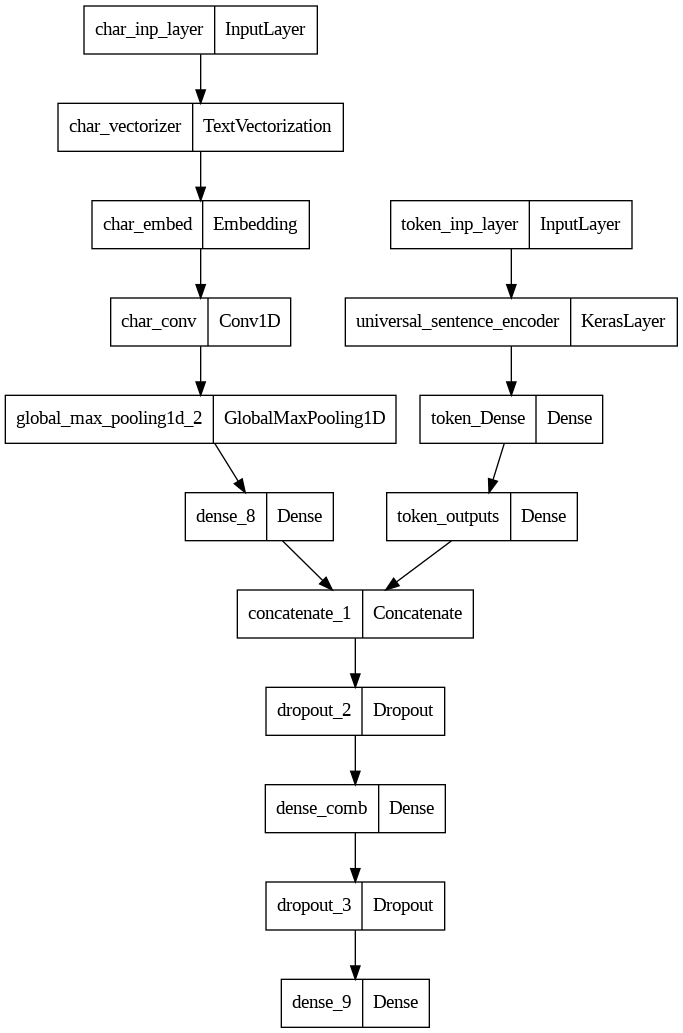

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_4)

In [ ]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

In [ ]:
#combining token and char data 

train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sent,train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices((train_labels_ohe))
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data,train_char_token_labels))
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sent,val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices((val_labels_ohe))
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data,val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
# Fit the model on tokens and chars
model_4_history = model_4.fit(train_char_token_dataset, # train on dataset of token and characters
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))
     

Epoch 1/3
562/562 [==============================] - 15s 19ms/step - loss: 1.2895 - accuracy: 0.4352 - val_loss: 0.9780 - val_accuracy: 0.6167
Epoch 2/3
562/562 [==============================] - 11s 19ms/step - loss: 1.0781 - accuracy: 0.5502 - val_loss: 0.9260 - val_accuracy: 0.6509
Epoch 3/3
562/562 [==============================] - 11s 19ms/step - loss: 1.0203 - accuracy: 0.5813 - val_loss: 0.9076 - val_accuracy: 0.6476


In [ ]:
print(model_4.evaluate(val_char_token_dataset))
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_pred = tf.argmax(model_4_pred_probs,axis=1)
baseline_4_res = calculate(val_labels_encoded,model_4_pred_pred)

# Model5: Transfer Learning with pretrained token emb + character emb + pos emb

In [ ]:
train_df["line_number"].value_counts()
     

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

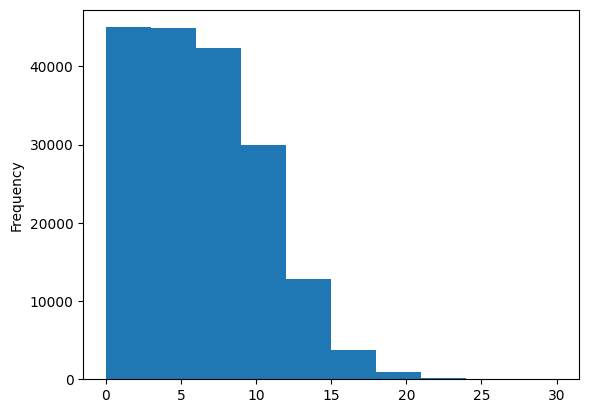

In [ ]:
train_df.line_number.plot.hist()


In [ ]:
depth = 15  

train_line_number_ohe = tf.one_hot(train_df['line_number'].tolist(),depth = depth)
val_line_number_ohe = tf.one_hot(val_df['line_number'].tolist(),depth = depth)
test_line_number_ohe = tf.one_hot(test_df['line_number'].tolist(),depth = depth)

In [ ]:
train_line_number_ohe

<tf.Tensor: shape=(180040, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

<Axes: ylabel='Frequency'>

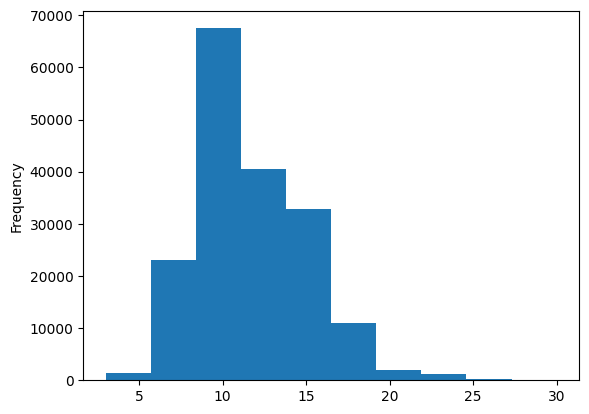

In [ ]:
train_df['total_lines'].plot.hist()

In [ ]:
depth_tl = 20
train_total_line_ohe = tf.one_hot(train_df['total_lines'].tolist(),depth = depth_tl)
val_total_line_ohe = tf.one_hot(val_df['total_lines'].tolist(),depth = depth_tl)
test_total_line_ohe = tf.one_hot(test_df['total_lines'].tolist(),depth = depth_tl)

In [ ]:

#token inputs
tok_inputs = Input(shape=[],dtype = tf.string,name="token_inputs") #pretrained asks for size(batch,) hence shape= []
tok_emb = tf_hub_embedding_layer(tok_inputs)
x = Dense(128,activation = 'relu',name = 'token_dense')(tok_emb)
tok_model = Model(tok_inputs,x)

# char inputs
char_inputs = layers.Input(shape=(1,), dtype="string",name='char_inputs')
char_vectors = tv_char(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(32),name = 'char_bilstm')(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)


#line_number inputs
line_n_inp = Input(shape = (15,),dtype=tf.int32, name="line_number_input")
x = Dense(32,activation = 'relu',name = 'line_number_dense')(line_n_inp)
line_model = Model(line_n_inp , x)


#total_lines
total_line_inp = Input(shape = (20,),dtype = tf.int32,name="total_lines_input")
y = Dense(32,activation = 'relu',name = 'total_line_dense')(total_line_inp)
total_line_model = Model(total_line_inp , y)

comb_emb = layers.Concatenate(name='tok_char_emb')([tok_model.output,
                                                    char_model.output])

z  = layers.Dropout(0.3)(comb_emb)
z = Dense(128,activation='relu',name='concatenate_tok_char_dsense')(z)
z = layers.Concatenate(name='line_n_post_n')([line_model.output,
                                              total_line_model.output,
                                              z])

output_layer = Dense(5,activation = 'softmax')(z)

model_5 = Model([line_model.input,
                 total_line_model.input,
                 tok_model.input,
                 char_model.input],
                output_layer )


In [ ]:
model_5.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['token_inputs[0][0]']    

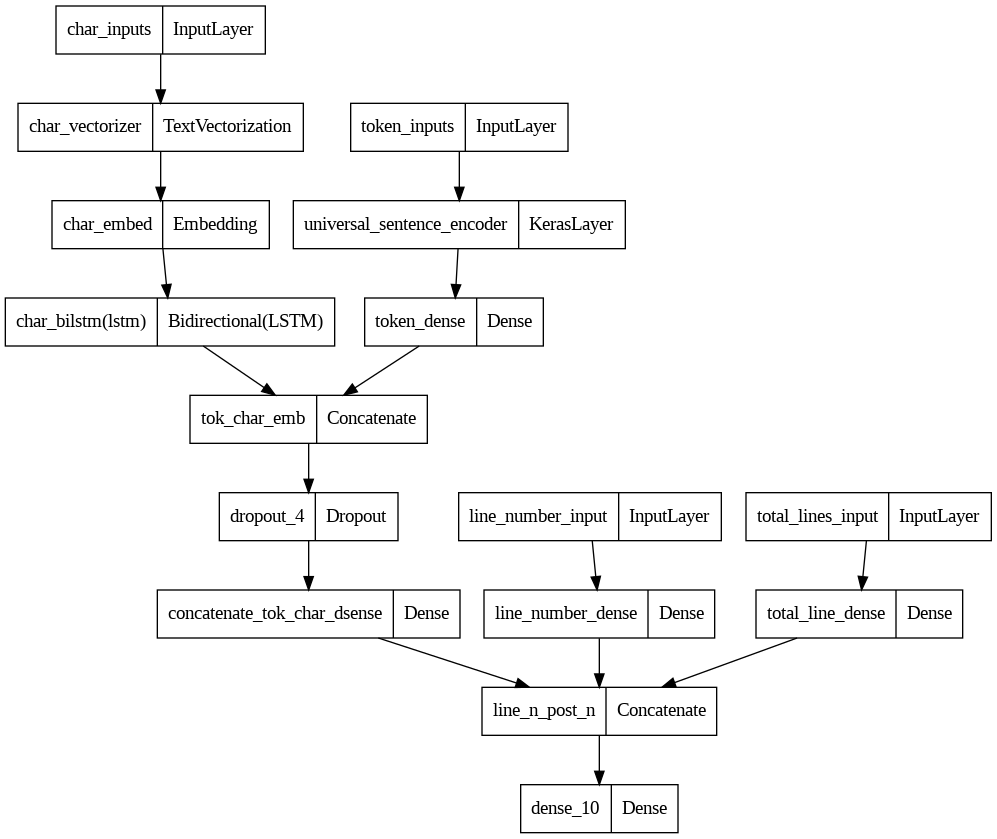

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model_5)

In [ ]:
# Compile token, char, positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # add label smoothing (examples which are really confident get smoothed a little)
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
     

In [ ]:
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_number_ohe,
                                                                train_total_line_ohe,
                                                                train_sent,
                                                                train_chars))

train_pos_char_token_label = tf.data.Dataset.from_tensor_slices(train_labels_ohe)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data,train_pos_char_token_label))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


#validation dataset
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_number_ohe, 
                                                              val_total_line_ohe,
                                                              val_sent,
                                                              val_chars))
val_pos_char_token_label = tf.data.Dataset.from_tensor_slices(val_labels_ohe)
val_pos_char_token_dataset = tf.data.Dataset.zip((val_pos_char_token_data,val_pos_char_token_label))
val_pos_char_token_dataset = val_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)




In [ ]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_token_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))
     

Epoch 1/3
562/562 [==============================] - 30s 36ms/step - loss: 1.0953 - accuracy: 0.7237 - val_loss: 0.9865 - val_accuracy: 0.8039
Epoch 2/3
562/562 [==============================] - 19s 34ms/step - loss: 0.9710 - accuracy: 0.8086 - val_loss: 0.9541 - val_accuracy: 0.8265
Epoch 3/3
562/562 [==============================] - 20s 36ms/step - loss: 0.9551 - accuracy: 0.8162 - val_loss: 0.9427 - val_accuracy: 0.8288


In [ ]:
print(model_5.evaluate(val_pos_char_token_dataset))
model_5_pred_probs = model_5.predict(val_pos_char_token_dataset)
model_5_pred_pred = tf.argmax(model_5_pred_probs,axis=1)
baseline_5_res = calculate(val_labels_encoded,model_5_pred_pred)

945/945 [==============================] - 21s 23ms/step - loss: 0.9412 - accuracy: 0.8305
[0.9412279725074768, 0.8304647207260132]
945/945 [==============================] - 19s 19ms/step
Recall:  0.8304647160068847
precision:  0.8294848079183831
f1:  0.8296058496074021
accuracy:  0.8304647160068847


In [ ]:
baseall_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": baseline_1_res,
                                  "pretrained_token_embed": baseline_2_res,
                                  "custom_char_embed_conv1d": baseline_3_res,
                                  "hybrid_char_token_embed": baseline_4_res,
                                  "tribrid_pos_char_token_embed": baseline_5_res})

all_model_results = baseall_model_results.transpose()
all_model_results

NameError: ignored

In [ ]:
model_5.save('skimlit_tribid_model')

In [ ]:
!cp skimlit_tribid_model -r /content/drive/MyDrive/Tensorflow_cert/skimlit_models

In [ ]:
path = '/content/drive/MyDrive/Tensorflow_cert/skimlit_models/skimlit_tribid_model/saved_model.pb'

loaded_model = tf.keras.models.load_model('/content/skimlit_tribid_model/saved_model.pb')

# Evaluate on test data

In [ ]:
test_pos_char_token_data = tf.data.Dataset.from_tensor_slices((
    test_line_number_ohe,test_total_line_ohe,test_sent,test_chars
))
test_pos_char_token_label = tf.data.Dataset.from_tensor_slices((
    test_labels_ohe
))
test_pos_char_token_dataset = tf.data.Dataset.zip((test_pos_char_token_data,test_pos_char_token_label))
test_pos_char_token_dataset = test_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [ ]:
test_line_number_ohe

In [ ]:
test_total_line_ohe

In [ ]:
test_sent[:10]

In [ ]:
test_chars

In [ ]:
test_pred_prob = model_5.predict(test_pos_char_token_dataset)
test_pred_val = tf.argmax(test_pred_prob,axis = 1)


In [ ]:
calculate(test_pred_val,test_labels_encoded)

In [ ]:
import json
!wget https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/skimlit_example_abstracts.json

In [ ]:
data = [
    {
        "abstract": "This RCT examined the efficacy of a manualized social intervention for children with HFASDs. Participants were randomly assigned to treatment or wait-list conditions. Treatment included instruction and therapeutic activities targeting social skills, face-emotion recognition, interest expansion, and interpretation of non-literal language. A response-cost program was applied to reduce problem behaviors and foster skills acquisition. Significant treatment effects were found for five of seven primary outcome measures (parent ratings and direct child measures). Secondary measures based on staff ratings (treatment group only) corroborated gains reported by parents. High levels of parent, child and staff satisfaction were reported, along with high levels of treatment fidelity. Standardized effect size estimates were primarily in the medium and large ranges and favored the treatment group.",
        "source": "https://pubmed.ncbi.nlm.nih.gov/20232240/",
        "details": "RCT of a manualized social treatment for high-functioning autism spectrum disorders"
    },
    {
        "abstract": "Postpartum depression (PPD) is the most prevalent mood disorder associated with childbirth. No single cause of PPD has been identified, however the increased risk of nutritional deficiencies incurred through the high nutritional requirements of pregnancy may play a role in the pathology of depressive symptoms. Three nutritional interventions have drawn particular interest as possible non-invasive and cost-effective prevention and/or treatment strategies for PPD; omega-3 (n-3) long chain polyunsaturated fatty acids (LCPUFA), vitamin D and overall diet. We searched for meta-analyses of randomised controlled trials (RCT's) of nutritional interventions during the perinatal period with PPD as an outcome, and checked for any trials published subsequently to the meta-analyses. Fish oil: Eleven RCT's of prenatal fish oil supplementation RCT's show null and positive effects on PPD symptoms. Vitamin D: no relevant RCT's were identified, however seven observational studies of maternal vitamin D levels with PPD outcomes showed inconsistent associations. Diet: Two Australian RCT's with dietary advice interventions in pregnancy had a positive and null result on PPD. With the exception of fish oil, few RCT's with nutritional interventions during pregnancy assess PPD. Further research is needed to determine whether nutritional intervention strategies during pregnancy can protect against symptoms of PPD. Given the prevalence of PPD and ease of administering PPD measures, we recommend future prenatal nutritional RCT's include PPD as an outcome.",
        "source": "https://pubmed.ncbi.nlm.nih.gov/28012571/",
        "details": "Formatting removed (can be used to compare model to actual example)"
    },
    {
        "abstract": "Mental illness, including depression, anxiety and bipolar disorder, accounts for a significant proportion of global disability and poses a substantial social, economic and heath burden. Treatment is presently dominated by pharmacotherapy, such as antidepressants, and psychotherapy, such as cognitive behavioural therapy; however, such treatments avert less than half of the disease burden, suggesting that additional strategies are needed to prevent and treat mental disorders. There are now consistent mechanistic, observational and interventional data to suggest diet quality may be a modifiable risk factor for mental illness. This review provides an overview of the nutritional psychiatry field. It includes a discussion of the neurobiological mechanisms likely modulated by diet, the use of dietary and nutraceutical interventions in mental disorders, and recommendations for further research. Potential biological pathways related to mental disorders include inflammation, oxidative stress, the gut microbiome, epigenetic modifications and neuroplasticity. Consistent epidemiological evidence, particularly for depression, suggests an association between measures of diet quality and mental health, across multiple populations and age groups; these do not appear to be explained by other demographic, lifestyle factors or reverse causality. Our recently published intervention trial provides preliminary clinical evidence that dietary interventions in clinically diagnosed populations are feasible and can provide significant clinical benefit. Furthermore, nutraceuticals including n-3 fatty acids, folate, S-adenosylmethionine, N-acetyl cysteine and probiotics, among others, are promising avenues for future research. Continued research is now required to investigate the efficacy of intervention studies in large cohorts and within clinically relevant populations, particularly in patients with schizophrenia, bipolar and anxiety disorders.",
        "source": "https://pubmed.ncbi.nlm.nih.gov/28942748/",
        "details": "Effect of nutrition on mental health"
    },
    {
        "abstract": "Hepatitis C virus (HCV) and alcoholic liver disease (ALD), either alone or in combination, count for more than two thirds of all liver diseases in the Western world. There is no safe level of drinking in HCV-infected patients and the most effective goal for these patients is total abstinence. Baclofen, a GABA(B) receptor agonist, represents a promising pharmacotherapy for alcohol dependence (AD). Previously, we performed a randomized clinical trial (RCT), which demonstrated the safety and efficacy of baclofen in patients affected by AD and cirrhosis. The goal of this post-hoc analysis was to explore baclofen's effect in a subgroup of alcohol-dependent HCV-infected cirrhotic patients. Any patient with HCV infection was selected for this analysis. Among the 84 subjects randomized in the main trial, 24 alcohol-dependent cirrhotic patients had a HCV infection; 12 received baclofen 10mg t.i.d. and 12 received placebo for 12-weeks. With respect to the placebo group (3/12, 25.0%), a significantly higher number of patients who achieved and maintained total alcohol abstinence was found in the baclofen group (10/12, 83.3%; p=0.0123). Furthermore, in the baclofen group, compared to placebo, there was a significantly higher increase in albumin values from baseline (p=0.0132) and a trend toward a significant reduction in INR levels from baseline (p=0.0716). In conclusion, baclofen was safe and significantly more effective than placebo in promoting alcohol abstinence, and improving some Liver Function Tests (LFTs) (i.e. albumin, INR) in alcohol-dependent HCV-infected cirrhotic patients. Baclofen may represent a clinically relevant alcohol pharmacotherapy for these patients.",
        "source": "https://pubmed.ncbi.nlm.nih.gov/22244707/",
        "details": "Baclofen promotes alcohol abstinence in alcohol dependent cirrhotic patients with hepatitis C virus (HCV) infection"
    }
]


abstracts = pd.DataFrame(data)

In [ ]:
abstracts.head()

In [ ]:
from spacy.lang.en import English
nlp =English()
sentencizer = nlp.create_pipe('sentencizer')
nlp.add_pipe(sentencizer)
doc = nlp(example_ab)

In [ ]:
#sentencizer = nlp.create_pipe('sentencizer')
#nlp.add_pipe('sentencizer')
doc = nlp(data[0]['abstract'])
abstract_lines = [str(sent)for sent in list(doc.sents)]

In [ ]:
total_lines_in_sample = len(abstract_lines)
sample_lines =[]
for i, line in enumerate(abstract_lines):
  sample_dict = {}
  sample_dict['text'] = str(line)
  sample_dict['line_number'] = i
  sample_dict['total_lines'] = total_lines_in_sample
  sample_lines.append(sample_dict)

In [ ]:
sample_lines

In [ ]:
test_abs_line_number = [line_n['line_number'] for line_n in sample_lines]
test_abstract_line_numbers_one_hot = tf.one_hot(test_abs_line_number,depth = 15)
test_abstract_line_numbers_one_hot

In [ ]:
# Get all total_lines values from sample abstract
test_abstract_total_lines = [line["total_lines"] for line in sample_lines]
# One-hot encode to same depth as training data, so model accepts right input shape
test_abstract_total_lines_one_hot = tf.one_hot(test_abstract_total_lines, depth=20)
test_abstract_total_lines_one_hot

In [ ]:
abs_chars = [char_split(sent)for sent in abstract_lines]
abs_chars

In [ ]:
test_abstract_line_numbers_one_hot

In [ ]:
test_abstract_total_lines_one_hot

In [ ]:
abstract_lines

In [ ]:
abs_chars

In [ ]:


pred_test_values = model_5.predict((test_abstract_line_numbers_one_hot,
                 test_abstract_total_lines_one_hot,
                 tf.constant(abstract_lines),
                 tf.constant(abs_chars)))

pred_test_values = tf.argmax(pred_test_values,axis=1)

In [ ]:
# Turn prediction class integers into string class names
test_abstract_pred_classes = [lb.classes_[i] for i in pred_test_values]
test_abstract_pred_classes

In [ ]:
for i, line in enumerate(abstract_lines):
  print(f"{test_abstract_pred_classes[i]}: {line}")

#Excersie

In [ ]:
chpt_path = 'checkoint_5/model_5.ckpt'
checkpoint = tf.keras.callbacks.ModelCheckpoint(chpt_path , monitor = 'val_loss' ,
                                                save_best_only = True , save_weights_only = True,
                                                )

early_call = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 4, restore_best_weights =True)




In [ ]:
# Fit the token, char and positional embedding model
history_m5_callbacks = model_5.fit(train_pos_char_token_dataset,
                              #steps_per_epoch=int(0.3 * len(train_pos_char_token_dataset)),
                              epochs=15,
                              validation_data=val_pos_char_token_dataset,
                             # validation_steps=int(0.3 * len(val_pos_char_token_dataset)),
                              callbacks = [checkpoint,early_call])
     

Epoch 1/15
5627/5627 [==============================] - 205s 36ms/step - loss: 0.8997 - accuracy: 0.8553 - val_loss: 0.8932 - val_accuracy: 0.8559
Epoch 2/15
5627/5627 [==============================] - 203s 36ms/step - loss: 0.8928 - accuracy: 0.8606 - val_loss: 0.8887 - val_accuracy: 0.8590
Epoch 3/15
5627/5627 [==============================] - 204s 36ms/step - loss: 0.8866 - accuracy: 0.8650 - val_loss: 0.8881 - val_accuracy: 0.8578
Epoch 4/15
5627/5627 [==============================] - 219s 39ms/step - loss: 0.8819 - accuracy: 0.8683 - val_loss: 0.8831 - val_accuracy: 0.8625
Epoch 5/15
5627/5627 [==============================] - 195s 35ms/step - loss: 0.8775 - accuracy: 0.8705 - val_loss: 0.8802 - val_accuracy: 0.8632
Epoch 6/15
5627/5627 [==============================] - 200s 35ms/step - loss: 0.8739 - accuracy: 0.8734 - val_loss: 0.8793 - val_accuracy: 0.8656
Epoch 7/15
5627/5627 [==============================] - 195s 35ms/step - loss: 0.8706 - accuracy: 0.8752 - val_loss: 0

#Model 7 glove

In [ ]:
embedding_dict={}
glove_path = '/content/glove.6B.100d.txt'
with open(glove_path) as f:
    for line in f:
        values = line.split()
        word = values[0]
        vectors = np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [ ]:
emb_matrix = np.zeros((max_tokens,embedding_dim))
emb_matrix.shape

(70, 100)

In [ ]:
len(word_index.keys())

45901

In [ ]:
embedding_dim  =100
hits= 0 
misses = 0

converted = []
missed = []
max_tokens = 40000
emb_matrix = np.zeros((max_tokens,embedding_dim))
for word,i in word_index.items():
  if i>max_tokens:
    break
  emb_vect = embedding_dict.get(word)
  if emb_vect  is not None:
    emb_matrix[i] = emb_vect
    hits+=1
    converted.append(word)
  else:
    misses+=1
    missed.append(word)
print('converted %d words (%dmisses)'% (hits,misses))      


converted 27244 words (12756misses)


In [ ]:
embedding_layer = layers.Embedding(max_tokens,
                              embedding_dim,
                              weights=[emb_matrix],
                              trainable=False,
                              input_length = 55)

GlobalAveragePooling1D()(Dense(64,activation = 'relu')(embedding_layer(train_seq[0:2])))

<tf.Tensor: shape=(2, 64), dtype=float32, numpy=
array([[1.32913098e-01, 4.67467159e-01, 9.24587250e-01, 2.30509683e-01,
        4.76359457e-01, 3.43931824e-01, 5.39553585e-05, 7.25470662e-01,
        5.42437196e-01, 5.80182076e-01, 1.28643017e-03, 3.44827294e-01,
        4.77331698e-01, 1.10676177e-01, 2.16072425e-01, 1.69181600e-01,
        1.20182224e-01, 1.67927742e-01, 8.46663141e-04, 5.95409274e-01,
        3.16846013e-01, 5.96752241e-02, 2.67432779e-02, 1.02067745e+00,
        2.20006760e-02, 1.53650761e-01, 1.06989935e-01, 8.98357630e-02,
        9.37659014e-03, 6.33235157e-01, 5.06767929e-01, 2.17856336e-02,
        0.00000000e+00, 8.37946594e-01, 1.24575250e-01, 7.01566339e-01,
        0.00000000e+00, 3.18990409e-01, 5.02732694e-01, 8.18685174e-01,
        1.05176523e-01, 0.00000000e+00, 1.37836203e-01, 2.33643293e-01,
        1.31327403e-03, 2.78871367e-03, 2.03123838e-01, 1.04933642e-02,
        5.83797507e-02, 6.07571490e-02, 8.92570019e-01, 1.25057553e-03,
        8.17216

In [ ]:
embedding_layer = layers.Embedding(max_tokens,
                              embedding_dim,
                              weights=[emb_matrix],
                              trainable=False,
                              input_length = 55)


inputs = Input(shape=(1,))                                       #pretrained asks for size(batch,) hence shape= []
pretrained_emb = embedding_layer(inputs)                       #takes input(None,seq_len)  -->(None,dim_len)
x = Dense(64,activation = 'relu')(pretrained_emb)              #inp(batch,dim)--->out(batch,dense_units)
x = layers.GlobalAveragePooling1D()(x)
outputs = Dense(5,activation = 'softmax')(x)                   #inp(batch,64)----->(batch,5)
model_7 = Model(inputs,outputs)                           
model_7.compile(loss="categorical_crossentropy",               # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_7.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 embedding_15 (Embedding)    (None, 1, 100)            4000000   
                                                                 
 dense_22 (Dense)            (None, 1, 64)             6464      
                                                                 
 global_average_pooling1d_6   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_23 (Dense)            (None, 5)                 325       
                                                                 
Total params: 4,006,789
Trainable params: 6,789
Non-trainable params: 4,000,000
____________________________________________

In [ ]:
model_7.fit(train_seq,train_labels_ohe,
            steps_per_epoch=int(0.1 * len(train_seq)/32),
            epochs=3,
            validation_data = (val_seq,val_labels_ohe),
            validation_steps=int(0.1 * len(val_seq)/32))

NameError: ignored

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
embedding_layer = layers.Embedding(max_tokens,
                              embedding_dim,
                              embeddings_initializer = tf.keras.initializers.Constant(emb_matrix),
                              trainable=False,
                              input_length = 55)


inputs = Input(shape=(None,))                                       #pretrained asks for size(batch,) hence shape= []
pretrained_emb = embedding_layer(inputs)                       #takes input(None,seq_len)  -->(None,dim_len)
x = Dense(64,activation = 'relu')(pretrained_emb)              #inp(batch,dim)--->out(batch,dense_units)
x = layers.GlobalAveragePooling1D()(x)
outputs = Dense(5,activation = 'softmax')(x)                   #inp(batch,64)----->(batch,5)
model_7_ = Model(inputs,outputs)                           
model_7_.compile(loss="categorical_crossentropy",               # if your labels are integer form (not one hot) use sparse_categorical_crossentropy
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_7_.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_21 (Embedding)    (None, None, 100)         4000000   
                                                                 
 dense_32 (Dense)            (None, None, 64)          6464      
                                                                 
 global_average_pooling1d_12  (None, 64)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_33 (Dense)            (None, 5)                 325       
                                                                 
Total params: 4,006,789
Trainable params: 6,789
Non-trainable params: 4,000,000
____________________________________________

In [ ]:
model_7_.fit(train_seq,train_labels_ohe,
            steps_per_epoch=int(0.1 * len(train_seq)/32),
            epochs=3,
            validation_data = (val_seq,val_labels_ohe),
            validation_steps=int(0.1 * len(val_seq)/32))

Epoch 1/3
562/562 [==============================] - 7s 8ms/step - loss: 1.3869 - accuracy: 0.4235 - val_loss: 1.2933 - val_accuracy: 0.4521
Epoch 2/3
562/562 [==============================] - 3s 6ms/step - loss: 1.2670 - accuracy: 0.4643 - val_loss: 1.2378 - val_accuracy: 0.4861
Epoch 3/3
558/562 [============================>.] - ETA: 0s - loss: 1.2262 - accuracy: 0.4871

562/562 [==============================] - 4s 7ms/step - loss: 1.2262 - accuracy: 0.4871 - val_loss: 1.2026 - val_accuracy: 0.4984


#BERT

In [ ]:
!pip3 install --quiet tensorflow-text
import tensorflow_text as text  # Imports TF ops for preprocessing.

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 16.7 MB/s eta 0:00:00


In [ ]:
preprocess = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert = hub.load('https://tfhub.dev/google/experts/bert/pubmed/2')

In [ ]:
bert_inputs = preprocess(train_sent)